In [11]:
#IMPORT NECESSARY PACKAGES
import CO2_functions
from CO2_functions import *

In [10]:
import importlib
importlib.reload(CO2_functions)
from CO2_functions import *

NameError: name 'CO2_functions' is not defined

In [4]:
date1,date2 = get_date_range()
LI_vent, Multiplexer, Vent_Anem_Temp, Picarro, \
= get_sql_data("Aug2019_LI_8100_Vent",\
              "Aug2019_Multiplexer","Aug2019_Vent_Anem_Temp",\
              "Aug2019_Picarro",date1,date2,'all')
Picarro = wind_add(Picarro,2)

Enter Start Date YYYY-mm-DD:  2019-10-01
Enter End Date YYYY-mm-DD:  2019-10-01


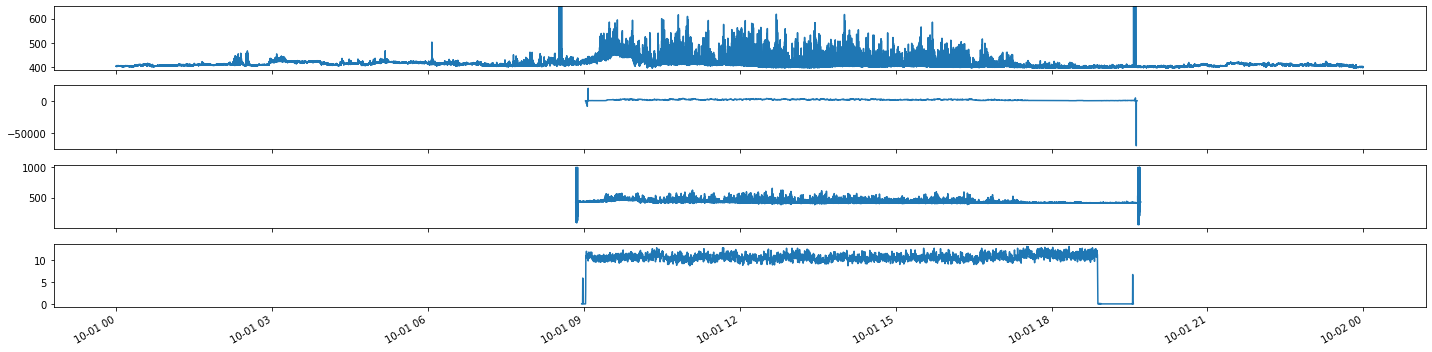

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-10-01 10:00:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-10-01 11:00:00


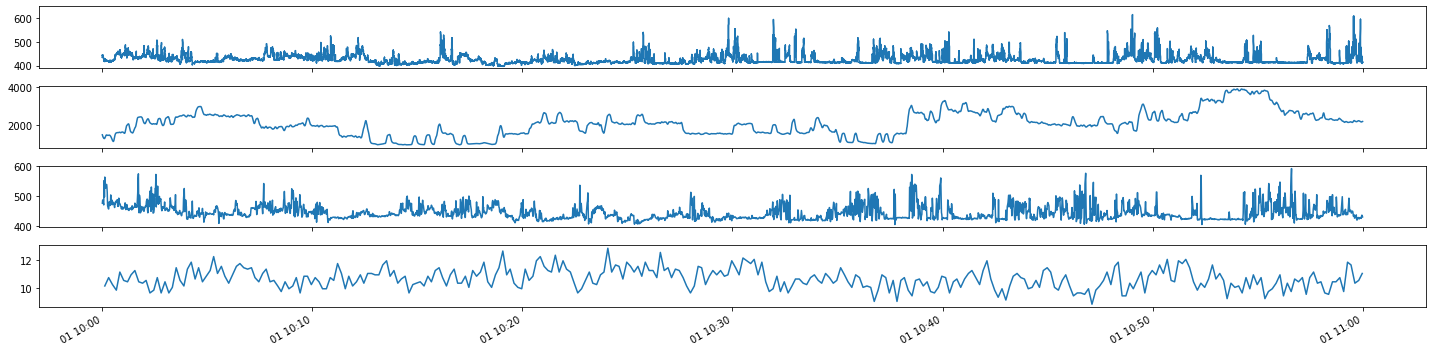

Is this an acceptable range?  y


In [6]:
Pic_clip,LI_clip,Multi_clip,Vent_clip = plot_refinement_all([[Picarro,'Local_DT','CO2'],[LI_vent,'Local_DT','CO2'],[Multiplexer,'Local_DT','CO2_3'],[Vent_Anem_Temp,'Local_DT','Velocity']])

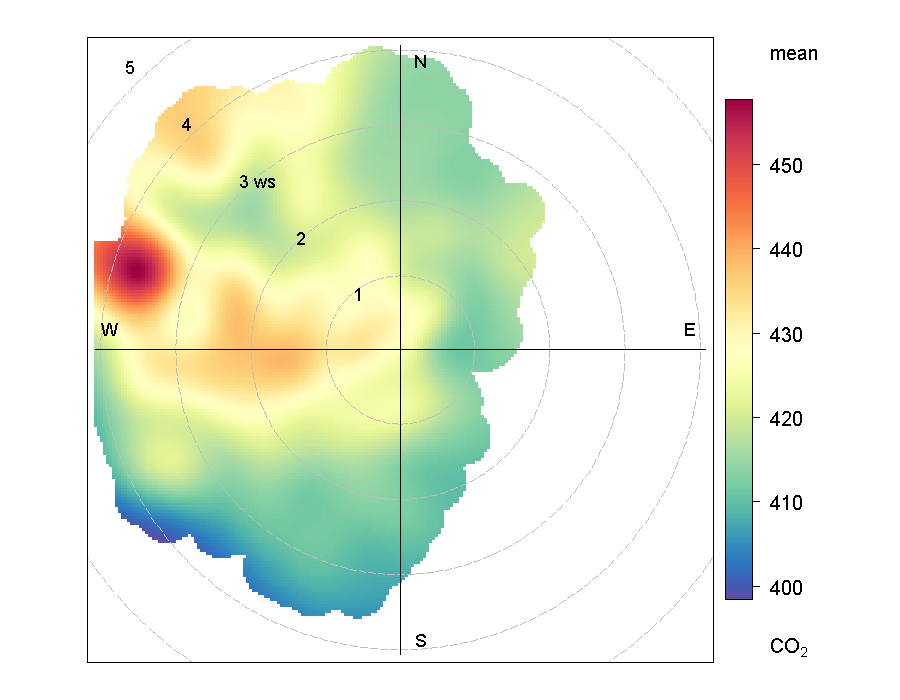

In [9]:
polar_plot(Pic_clip,'CO2')


In [1]:
import pickle
import pandas as pd


In [14]:
df = pd.read_pickle('All_actualET_Spikes.pkl')
lags = create_lag_df(df)
lags.loc[(lags['Actual_DT']>'2019-10-01 00:00:00')&(lags['Actual_DT']<'2019-10-02 00:00:00')]

,Actual_DT,Actual_ET,LI_8100_Vent,Multiplexer_CO2_1,Multiplexer_CO2_2,Multiplexer_CO2_3,Picarro_ANEM,Picarro_CO2,Vent_Anem_Temp
342,2019-10-01 08:29:00,1.569940e+09,NaN,NaN,NaN,NaN,NaN,-132.5,NaN
343,2019-10-01 08:31:00,1.569940e+09,NaN,NaN,NaN,NaN,NaN,-132.3,NaN
344,2019-10-01 08:32:00,1.569940e+09,NaN,NaN,NaN,NaN,NaN,-132.3,NaN
345,2019-10-01 19:33:00,1.569980e+09,NaN,NaN,NaN,NaN,NaN,-132.8,NaN
346,2019-10-01 19:34:00,1.569980e+09,NaN,NaN,NaN,NaN,NaN,-132.8,NaN
347,2019-10-01 19:35:00,1.569980e+09,NaN,NaN,NaN,NaN,NaN,-132.8,NaN
381,2019-10-01 08:29:00,1.569940e+09,NaN,NaN,NaN,NaN,-129.9,NaN,NaN
382,2019-10-01 08:31:00,1.569940e+09,NaN,NaN,NaN,NaN,-129.6,NaN,NaN
383,2019-10-01 08:32:00,1.569940e+09,NaN,NaN,NaN,NaN,-129.7,NaN,NaN
384,2019-10-01 19:34:00,1.569980e+09,NaN,NaN,NaN,NaN,-130.4,NaN,NaN


In [9]:
df.to_pickle('Spike_ETs.pkl')

In [ ]:
#x = [1,.866,.707,.5,0,-.5,-.707,-.866,-1,-.866,-.707,-.5,0,.5,.707,.866]
#y=[0,.5,.707,.866,1,.866,.707,.5,0,-.5,-.707,-.866,-1,-.866,-.707,-.5]
x = [1]
y = [-3]
df=pd.DataFrame({'ANEM_X':x,'ANEM_Y':y})
df = wind_add(df)
df